**FIT5217 Assignment 2: Neural Chef Assistance**  
**Name: Darren Jer Shien Yee**  
**Student ID: 31237223**

**Implementation of Baseline 1: RNN without Attention**

In [615]:
## Requirements
!pip3 install nltk
!pip3 install tensorboardX
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import gensim.downloader as api
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

**Implementation of Baseline 1: Language Method imported from RNN code (Imported from Tutorial Code)**

In [616]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
        self.unique_words = []

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.unique_words.append(word)
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**Implementation of Baseline 1: Unicode and ASCII method to preprocess data (Imported and Modified from Tutorial Code)**

In [617]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase only (since numerical is crucial here as opposed to lab code)
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace('\t', ' ')
    return s

**Implementation of Baseline 1: Method to read data from provided CSV (Imported and Modified from Tutorial Code)**

In [406]:
import pandas as pd

def readLangs(reverse=False):
    # Read the CSV file
    train_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/train.csv')
    valid_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/dev.csv')
    test_df = pd.read_csv('Cooking_Dataset/Cooking_Dataset/test.csv')
    
    train_df.fillna('', inplace=True)
    valid_df.fillna('', inplace=True)
    test_df.fillna('', inplace=True)
    
    train_ingredients = train_df['Ingredients']
    train_recipes = train_df['Recipe']
    valid_ingredients = valid_df['Ingredients']
    valid_recipes = valid_df['Recipe']    
    test_ingredients = test_df['Ingredients']
    test_recipes = test_df['Recipe']
    
    train_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(train_ingredients, train_recipes)]
    valid_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(valid_ingredients, valid_recipes)]
    test_pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(test_ingredients, test_recipes)]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('Recipe')
        output_lang = Lang('Ingredients')
    else:
        input_lang = Lang('Ingredients')
        output_lang = Lang('Recipe')
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs

**Implementation of Baseline 1: Preprocess data and intialise language using the methods above (Imported and Modified from Tutorial Code)**

In [618]:
MAX_LENGTH = 150
# Filters Pairs that do not fit the max_length restriction
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH
    
# Applies filterPairs to all pairs
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Metric Calculation
def length_metric (pairs):
    ing_len = []
    rec_len = []
    for pair in pairs:
        ing_len.append(len(pair[0].split(' ')))
        rec_len.append(len(pair[1].split(' ')))
    mean_ing_len = round(np.mean(ing_len), 2)
    mean_rec_len = round(np.mean(rec_len), 2)
    max_ing_len = np.max(ing_len)
    max_rec_len = np.max(rec_len)
    min_ing_len = np.min(ing_len)
    min_rec_len = np.min(rec_len)
    output_string = "Mean ingredient length: {}\n".format(mean_ing_len)
    output_string += "Mean recipe length: {}\n".format(mean_rec_len)
    output_string += "Maximum ingredient length: {}\n".format(max_ing_len)
    output_string += "Maximum recipe length: {}\n".format(max_rec_len)
    output_string += "Minimum ingredient length: {}\n".format(min_ing_len)
    output_string += "Minimum recipe length: {}\n".format(min_rec_len)
    return output_string
    
# Filter pairs method for testing data which saves the test_idx for csv insertion
def filterPairs_test(pairs):
    filtered_pairs = []
    saved_indices = []
    for i, pair in enumerate(pairs):
        if filterPair(pair):
            filtered_pairs.append(pair)
            saved_indices.append(i)
    return filtered_pairs, saved_indices

In [408]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read train pairs: %s" % len(train_pairs),",test pairs: %s" % len(test_pairs),",dev pairs: %s" % len(valid_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs, test_indices = filterPairs_test(test_pairs)
    print ("________________Train_Data_Metric________________")
    print("Trimmed to %s train pairs" % len(train_pairs))
    print (length_metric(train_pairs))
    print ("________________Test_Data_Metric________________")
    print("Trimmed to %s test pairs" % len(test_pairs))
    print (length_metric(test_pairs))
    print ("________________Dev_Data_Metric________________")
    print("Trimmed to %s dev pairs" % len(valid_pairs))
    print (length_metric(valid_pairs))
    print("Counting words...")
    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs, test_indices

input_lang, output_lang, train_pairs, valid_pairs, test_pairs ,test_indices= prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read train pairs: 101340 ,test pairs: 778 ,dev pairs: 797
________________Train_Data_Metric________________
Trimmed to 79894 train pairs
Mean ingredient length: 45.98
Mean recipe length: 76.57
Maximum ingredient length: 149
Maximum recipe length: 149
Minimum ingredient length: 1
Minimum recipe length: 1

________________Test_Data_Metric________________
Trimmed to 629 test pairs
Mean ingredient length: 44.15
Mean recipe length: 76.0
Maximum ingredient length: 145
Maximum recipe length: 149
Minimum ingredient length: 1
Minimum recipe length: 3

________________Dev_Data_Metric________________
Trimmed to 644 dev pairs
Mean ingredient length: 44.24
Mean recipe length: 76.62
Maximum ingredient length: 149
Maximum recipe length: 149
Minimum ingredient length: 2
Minimum recipe length: 3

Counting words...
Counted words:
Ingredients 37056
Recipe 35620
['2 c  ketchup 1/2 c  worcestershire sauce 2    cloves garlic cloves -- 1/2 c  vinegar minced 1/4 c  soy sauce 2/3 c  chopped onion 1/4 c  packed

**Implementation of Baseline 1: Encoder RNN for seq2seq model without attention (Imported from Tutorial Code)**

In [409]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Implementation of Baseline 1: Decoder RNN for seq2seq model without attention (Imported from Tutorial Code)**

In [410]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 1: Processing methods for train iter (Imported from Tutorial Code)**

In [411]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**Implementation of Baseline 1: Train method for seq2seq model without attention (Imported from Tutorial Code)**

In [620]:
# Set Teacher Forcing to 1
teacher_forcing_ratio = 1
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


**Implementation of Baseline 1: Validation method for seq2seq model without attention**

In [413]:
def valid(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 1: Time method for train iter method (Imported from Tutorial Code)** 

In [414]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**Implementation of Baseline 1: Train iter method (Imported and modified from Tutorial Code)**

In [621]:
def trainIters(encoder, decoder, n_iters,train_pairs,valid_pairs, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    # Using Adam instead of SGD as instructed
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    valid_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # Extract Train and Valid Pairs and calculate loss using methods above
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = valid_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        # Save data points for plot / print losses between iterations
        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 1: Evaluation methods to check performance of baseline 1 (Imported from Tutorial Code)**

In [416]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [417]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**Implementation of Baseline 1: Creating instance of baseline 1 and training (Hidden Size = 256, Teacher Forcing = 1, N_Iter = 10000, MAX_LENGTH = 150**

In [418]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 1000
baseline1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline1_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
baseline1_plot_train_losses,baseline1_plot_valid_losses = trainIters(baseline1_encoder, baseline1_decoder, n_iter ,train_pairs,valid_pairs, print_every = print_every,plot_every=plot_every)

3m 24s (- 30m 44s) (1000 10%) Train Loss: 5.2224 | Validation Loss: 5.4974
6m 58s (- 27m 52s) (2000 20%) Train Loss: 4.2244 | Validation Loss: 7.4348
10m 22s (- 24m 12s) (3000 30%) Train Loss: 4.0044 | Validation Loss: 7.2395
13m 47s (- 20m 41s) (4000 40%) Train Loss: 3.8252 | Validation Loss: 6.6394
17m 16s (- 17m 16s) (5000 50%) Train Loss: 3.6986 | Validation Loss: 7.3387
20m 44s (- 13m 49s) (6000 60%) Train Loss: 3.6498 | Validation Loss: 7.2527
24m 5s (- 10m 19s) (7000 70%) Train Loss: 3.6240 | Validation Loss: 6.4726
27m 25s (- 6m 51s) (8000 80%) Train Loss: 3.5497 | Validation Loss: 6.7959
30m 47s (- 3m 25s) (9000 90%) Train Loss: 3.4815 | Validation Loss: 6.5469
34m 21s (- 0m 0s) (10000 100%) Train Loss: 3.4599 | Validation Loss: 6.5811


**Implementation of Baseline 2: RNN with Attention (Imported from Tutorial Code)**

In [419]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 2: Train method for RNN with attention (Imported from Tutorial Code)**

In [622]:
# Set Teacher Forcing to 1 as required
teacher_forcing_ratio = 1.0
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


**Implementation of Baseline 2: Validation method**

In [421]:
def valid_attn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**Implementation of Baseline 2: Train iter method for RNN with attention (Imported from Tutorial Code)**

In [623]:
# Same comments as trainIters for baseline 1, the only difference is that it calls the attention variation of train and test instead
def trainIters_attn(encoder, decoder, n_iters,print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_train_losses = []
    plot_valid_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_valid_loss_total = 0  # Reset every print_every
    plot_valid_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    validation_pairs = [tensorsFromPair(random.choice(valid_pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        training_input_tensor = training_pair[0]
        training_target_tensor = training_pair[1]

        valid_pair = validation_pairs[iter - 1]
        valid_input_tensor = valid_pair[0]
        valid_target_tensor = valid_pair[1]

        train_loss = train_attn(training_input_tensor, training_target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss
        
        valid_loss = valid_attn(valid_input_tensor, valid_target_tensor, encoder,
             decoder, criterion)
        print_valid_loss_total += valid_loss
        plot_valid_loss_total += valid_loss

        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print_valid_loss_avg = print_valid_loss_total / print_every
            print_valid_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f | Validation Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                                             iter, iter / n_iters * 100,
                                                                             print_train_loss_avg, print_valid_loss_avg))
        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_valid_loss_avg = plot_valid_loss_total / plot_every
            plot_valid_losses.append(plot_valid_loss_avg)
            plot_valid_loss_total = 0
    return plot_train_losses,plot_valid_losses


**Implementation of Baseline 2: Initialising instance of RNN with attention (Hidden Size = 256, Teacher Forcing = 1, N_Iter = 10000, MAX_LENGTH = 150)**

In [423]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
baseline2_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
baseline2_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_train_losses,plot_valid_losses = trainIters_attn(baseline2_encoder, baseline2_decoder, 10000, print_every=1000)

4m 47s (- 43m 8s) (1000 10%) Train Loss: 4.9415 | Validation Loss: 5.8065
9m 36s (- 38m 26s) (2000 20%) Train Loss: 4.2183 | Validation Loss: 7.6959
14m 16s (- 33m 18s) (3000 30%) Train Loss: 3.9192 | Validation Loss: 7.2412
18m 49s (- 28m 14s) (4000 40%) Train Loss: 3.8428 | Validation Loss: 6.7070
23m 29s (- 23m 29s) (5000 50%) Train Loss: 3.7094 | Validation Loss: 6.5539
28m 13s (- 18m 48s) (6000 60%) Train Loss: 3.6495 | Validation Loss: 6.5823
32m 58s (- 14m 7s) (7000 70%) Train Loss: 3.5650 | Validation Loss: 6.6538
37m 35s (- 9m 23s) (8000 80%) Train Loss: 3.5699 | Validation Loss: 6.4216
42m 18s (- 4m 42s) (9000 90%) Train Loss: 3.5429 | Validation Loss: 6.7817
47m 1s (- 0m 0s) (10000 100%) Train Loss: 3.5028 | Validation Loss: 6.6035


**Implementation of Baseline 2: Evaluation method for RNN with Attention (Imported from Tutorial Code)**

In [424]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [425]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**Extension 1: Data Preprocessing Model (Stopwords Initialisation)**

In [624]:
# Recipe stopwords that commonly appear that do not represent any ingredients (used to preprocess it)
# This list was generated by ChatGPT3.5 + some of the words are added based on my experiments
recipe_stopwords = [
    'preheat', 'oven', 'bake', 'baking', 'baked', 'bakes',
    'minutes', 'hour', 'hours', 'minutes', 'second', 'seconds',
    'degrees', 'celsius', 'fahrenheit',
    'medium', 'low', 'high', 'heat','cold', 'stir', 'simmer', 'boil', 'cook', 'grill',
    'whisk', 'mix', 'combine', 'fold', 'blend', 'puree', 'chop', 'dice', 'slice',
    'peel', 'mince', 'drizzle', 'sprinkle', 'garnish', 'marinate', 'brush',
    'refrigerate', 'chill', 'cool', 'freeze', 'thaw', 'room', 'temperature',
    'bowl', 'plate', 'pan', 'pot', 'skillet', 'saucepan', 'baking', 'dish',
    'tray', 'oven', 'sheet', 'foil', 'parchment', 'paper', 'whisk', 'spatula',
    'spoon', 'knife', 'cutting', 'board', 'tongs', 'fork', 'mixer', 'blender',
    'food', 'processor', 'grater', 'peeler', 'sifter', 'rolling', 'pin', 'oven', 
    'mitts', 'rack', 'cooling', 'wire', 'timer', 'timer', 'recipe', 'directions', 
    'ingredients', 'instructions', 'method', 'step', 'steps', 'serve', 'serving', 
    'makes', 'yield', 'yield:', 'yields', 'size', 'number', 'portion', 'portions', 
    'note', 'notes', 'tip', 'tips', 'variations', 'version', 'versions', 'credit', 
    'credits', 'source', 'sources', 'adapted', 'adaptation', 'adaptations', 'based', 
    'courtesy', 'original', 'author', 'authors', 'website', 'link', 'links', 'video', 
    'videos', 'facebook', 'instagram', 'twitter', 'pinterest', 'youtube', 'email', 
    'subscribe', 'rss', 'save', 'print', 'rate', 'comment', 'share', 'subscribe', 
    'like', 'love', 'follow', 'pin', 'pinning', 'tweet', 'email', 'yum', 'instagram', 
    'snapchat', 'facebook', 'twitter', 'pinterest', 'linkedin', 'reddit', 'tumblr', 
    'whatsapp', 'telegram', 'messenger', 'sms', 'message', 'chat', 'print', 'kitchen', 
    'tip', 'tips', 'trick', 'tricks', 'hack', 'hacks', 'kitchen', 'kitchens', 'home', 
    'homes', 'family', 'families', 'friend', 'friends', 'guest', 'guests', 'love', 
    'lover', 'lovers', 'party', 'parties', 'holiday', 'holidays', 'season', 'seasons', 
    'occasion', 'occasions', 'day', 'days', 'night', 'nights', 'morning', 'mornings', 
    'afternoon', 'afternoons', 'evening', 'evenings', 'week', 'weeks', 'month', 'months', 
    'year', 'years', 'today', 'tomorrow', 'yesterday', 'fresh', 'from', 'the', 'store', 
    'grocery', 'groceries', 'shop', 'shopping', 'shopping', 'list', 'lists', 'order', 
    'orders', 'online', 'offline', 'local', 'farm', 'market', 'markets', 'buy', 'purchase', 
    'sell', 'sold', 'sold', 'out', 'brand', 'brands', 'company', 'companies', 'product', 
    'products', 'item', 'items', 'stock', 'store', 'stores', 'store', 'cupboard', 'pantry', 
    'cabinet', 'cabinets', 'shelf', 'shelves', 'freezer', 'fridge', 'refrigerator', 'appliance', 
    'appliances', 'equipment', 'accessory', 'accessories', 'tool', 'tools', 'utensil', 'utensils', 
    'gadget', 'gadgets', 'ingredient', 'ingredients', 'shop', 'shopping', 'store', 'supermarket', 
    'grocery', 'groceries', 'product', 'products', 'item', 'items', 'market', 'markets', 'local', 
    'online', 'organic', 'fresh', 'best', 'quality', 'brand', 'brands', 'company', 'companies', 
    'sale', 'discount', 'offer', 'deal', 'special', 'new', 'hot', 'trend', 'trending', 'popular', 
    'favorite', 'essential', 'basic', 'must', 'need', 'want', 'buy', 'purchase', 'sell', 'sold', 
    'stock', 'top', 'high', 'low', 'price', 'cost', 'cheap', 'expensive', 'affordable', 'budget', 
    'value', 'range', 'selection', 'variety', 'choice', 'option', 'flavor', 'flavors', 'taste', 
    'tastes', 'texture', 'textures', 'aroma', 'aromas', 'color', 'colors', 'colour', 'colours', 
    'style', 'styles', 'type', 'types', 'kind', 'kinds', 'size', 'sizes', 'amount', 'portion', 
    'portions', 'quantity', 'measure', 'measures', 'weight', 'volume', 'piece', 'pieces', 'bit', 
    'bits', 'part', 'parts', 'whole', 'half', 'quarter', 'third', 'eighth', 'sixteenth', 'tablespoon', 
    'tablespoons', 'teaspoon', 'teaspoons', 'cup', 'cups', 'pint', 'pints', 'quart', 'quarts', 
    'gallon', 'gallons', 'ounce', 'ounces', 'pound', 'pounds', 'gram', 'grams', 'kilogram', 
    'kilograms', 'liter', 'liters', 'milliliter', 'milliliters', 'inch', 'inches', 'foot', 
    'feet', 'yard', 'yards', 'meter', 'meters', 'centimeter', 'centimeters', 'kilometer', 
    'kilometers', 'mile', 'miles', 'small', 'medium', 'large', 'size', 'sized', 'big', 'bigger', 
    'biggest', 'tiny', 'tinier', 'tiniest', 'mini', 'minis', 'miniature', 'micro', 'miniature', 
    'average', 'normal', 'standard', 'fine', 'finest', 'finer', 'best', 'better', 'worst', 
    'least', 'most', 'more', 'fewer', 'few', 'lots', 'plenty', 'ton', 'tons', 'great', 'greater', 
    'greatest', 'awesome', 'fantastic', 'amazing', 'good', 'better', 'best', 'excellent', 
    'wonderful', 'remarkable', 'outstanding', 'brilliant', 'superb', 'fabulous', 'terrific', 
    'exceptional', 'phenomenal', 'splendid', 'extraordinary', 'magnificent', 'top-notch', 
    'first-rate', 'high-quality', 'premium', 'deluxe', 'luxury', 'high-end', 'superior', 
    'supreme', 'ultimate', 'divine', 'heavenly', 'fab', 'fancy', 'lux', 'lush', 'posh', 
    'swanky', 'chic', 'classy', 'elegant', 'fashionable', 'stylish', 'trendy', 'up-to-date', 
    'hip', 'cool', 'trendsetting', 'cutting-edge', 'innovative', 'forward-thinking', 
    'progressive', 'modern', 'contemporary', 'sleek', 'chic', 'tasteful', 'sophisticated', 
    'cultured', 'polished', 'refined', 'classic', 'timeless', 'nostalgic', 'vintage','medium', 
    'large', 'small','chopped','lb','finely','thinly','desired','lg','md','each','or','can','delicious','bout','for','as']


**Extension 1: Clean Text Method for preprocessing**

In [427]:
import re
def clean_text(text,stopwords,ingredients = False):
    # Define regular expression pattern to match numeric values and units
    amount_pattern = r'\b[\d.]+(?:\s*(?:g|kg|l|ml|tsp|tbsp|cup|pint|quart|oz|c|tb|ts|b|ea|pk|t|can|cups|cn|ounce)\b)?'
    # Remove numeric values and units from the text
    text = re.sub(amount_pattern, '', text)

    # Remove irrelevant information like advertisements, website navigation elements, etc.
    # Assuming such information may be enclosed within angle brackets or parentheses
    bracket_pattern = r'<[^>]*>|(\([^)]*\))'
    remove_words = r'-rrb-|-lrb-'
    # Remove text inside angle brackets and parentheses
    cleaned_text = re.sub(bracket_pattern, '', text)
    cleaned_text = re.sub(remove_words, '', cleaned_text)
    # Create a regex pattern to match the specified stopwords surrounded by spaces
    if ingredients:
        pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stopwords) + r')\b'
        cleaned_text = re.sub(pattern, '', cleaned_text)

    # Handle missing data and standardize text format
    cleaned_text = cleaned_text.lower()  # Convert text to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Remove punctuation
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces
    return cleaned_text

**Extension 1: Data filtering method (slight changes compared to baseline)**

In [625]:
# Filters based on max length
def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
        len(p[1].split(' ')) <= MAX_LENGTH

# Applies filterPairs to all pairs
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Metric to calculate for data information
def length_metric (pairs):
    ing_len = []
    rec_len = []
    for pair in pairs:
        ing_len.append(len(pair[0].split(' ')))
        rec_len.append(len(pair[1].split(' ')))
    mean_ing_len = round(np.mean(ing_len), 2)
    mean_rec_len = round(np.mean(rec_len), 2)
    max_ing_len = np.max(ing_len)
    max_rec_len = np.max(rec_len)
    min_ing_len = np.min(ing_len)
    min_rec_len = np.min(rec_len)
    output_string = "Mean ingredient length: {}\n".format(mean_ing_len)
    output_string += "Mean recipe length: {}\n".format(mean_rec_len)
    output_string += "Maximum ingredient length: {}\n".format(max_ing_len)
    output_string += "Maximum recipe length: {}\n".format(max_rec_len)
    output_string += "Minimum ingredient length: {}\n".format(min_ing_len)
    output_string += "Minimum recipe length: {}\n".format(min_rec_len)
    return output_string

# filterPairs method for test which saves index as well
def filterPairs_test(pairs):
    filtered_pairs = []
    saved_indices = []
    for i, pair in enumerate(pairs):
        if filterPair(pair):
            filtered_pairs.append(pair)
            saved_indices.append(i)
    return filtered_pairs, saved_indices

**Extension 1: Preprocess train,test and dev data**

In [429]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, valid_pairs, test_pairs = readLangs(reverse)
    print("Read train pairs: %s" % len(train_pairs),",test pairs: %s" % len(test_pairs),",dev pairs: %s" % len(valid_pairs))
    train_pairs = filterPairs(train_pairs)
    valid_pairs = filterPairs(valid_pairs)
    test_pairs, test_indices = filterPairs_test(test_pairs)
    print ("________________Train_Data_Metric________________")
    print("Trimmed to %s train pairs" % len(train_pairs))
    print (length_metric(train_pairs))
    print ("________________Test_Data_Metric________________")
    print("Trimmed to %s test pairs" % len(test_pairs))
    print (length_metric(test_pairs))
    print ("________________Dev_Data_Metric________________")
    print("Trimmed to %s dev pairs" % len(valid_pairs))
    print (length_metric(valid_pairs))
    print("Counting words...")
    for pair in train_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in valid_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    for pair in test_pairs:
        pair[0] = clean_text(pair[0],recipe_stopwords,True)
        pair[1] = clean_text(pair[1],recipe_stopwords,False)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, valid_pairs, test_pairs, test_indices

input_lang, output_lang, train_pairs, valid_pairs, test_pairs ,test_indices= prepareData('ingredients', 'recipe', False)
print(random.choice(train_pairs))

Read train pairs: 101340 ,test pairs: 778 ,dev pairs: 797
________________Train_Data_Metric________________
Trimmed to 80240 train pairs
Mean ingredient length: 46.05
Mean recipe length: 76.88
Maximum ingredient length: 150
Maximum recipe length: 150
Minimum ingredient length: 1
Minimum recipe length: 1

________________Test_Data_Metric________________
Trimmed to 629 test pairs
Mean ingredient length: 44.15
Mean recipe length: 76.0
Maximum ingredient length: 145
Maximum recipe length: 149
Minimum ingredient length: 1
Minimum recipe length: 3

________________Dev_Data_Metric________________
Trimmed to 646 dev pairs
Mean ingredient length: 44.25
Mean recipe length: 76.84
Maximum ingredient length: 149
Maximum recipe length: 150
Minimum ingredient length: 2
Minimum recipe length: 3

Counting words...
Counted words:
Ingredients 16481
Recipe 31389
['chuck steak thick stalks celery cream of mushroom soup potatoes onion soup water carrots', 'heat oven to degrees and place a sheet of tin foil 

**Extension 1: Run new model on preprocessed data (Hidden Size = 256, Teacher Forcing = 1, N_Iter = 10000, MAX_LENGTH = 150)**

In [430]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
extension1_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
extension1_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_extension1_train_losses,plot_extension1_valid_losses = trainIters_attn(extension1_encoder, extension1_decoder, 10000, print_every=1000)

3m 17s (- 29m 36s) (1000 10%) Train Loss: 5.4734 | Validation Loss: 7.0741
6m 31s (- 26m 6s) (2000 20%) Train Loss: 4.6433 | Validation Loss: 6.8594
9m 36s (- 22m 24s) (3000 30%) Train Loss: 4.4147 | Validation Loss: 6.5008
12m 52s (- 19m 18s) (4000 40%) Train Loss: 4.2761 | Validation Loss: 6.9000
16m 3s (- 16m 3s) (5000 50%) Train Loss: 4.1424 | Validation Loss: 6.7557
19m 10s (- 12m 47s) (6000 60%) Train Loss: 4.0436 | Validation Loss: 6.7828
22m 14s (- 9m 31s) (7000 70%) Train Loss: 3.9765 | Validation Loss: 6.6653
25m 15s (- 6m 18s) (8000 80%) Train Loss: 3.9731 | Validation Loss: 6.7593
28m 17s (- 3m 8s) (9000 90%) Train Loss: 3.8899 | Validation Loss: 6.7899
31m 21s (- 0m 0s) (10000 100%) Train Loss: 3.8810 | Validation Loss: 6.7665


**Extension 2: Stacking Layers (Modified Encoder for Layers)**

In [628]:
class EncoderRNN_Layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialises N number of GRU layers based on input
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # Initialise hidden layers correctly according to layer size
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


**Extension 2: Stacking Layers (Modified Decoder for Layers)**

In [629]:
class AttnDecoderRNN_Layers(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers, dropout_p=0.1, max_length=200):
        super(AttnDecoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
            # Initialises N number of GRU layers based on input
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        # Update weights according to new dimensions that hidden and encoder outputs now has
        attn_weights = F.softmax(torch.bmm(hidden[-1].unsqueeze(0), encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        # Initialise hidden layers correctly according to layer size
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

**Extension 2: Run new 2-layered model (Hidden Size = 256, Teacher Forcing = 1, N_Iter = 10000, MAX_LENGTH = 150)**

In [433]:
hidden_size = 256
n_iter = 10000
plot_every = 100
print_every = 100
extension2_encoder = EncoderRNN_Layers(input_lang.n_words, hidden_size, num_layers=2).to(device)
extension2_decoder = AttnDecoderRNN_Layers(hidden_size, output_lang.n_words, num_layers=2, dropout_p=0.1).to(device)
plot_extension2_train_losses,plot_extension2_valid_losses = trainIters_attn(extension2_encoder, extension2_decoder, 10000, print_every=1000)

3m 34s (- 32m 9s) (1000 10%) Train Loss: 5.4925 | Validation Loss: 6.5116
7m 2s (- 28m 9s) (2000 20%) Train Loss: 4.6440 | Validation Loss: 6.7581
10m 24s (- 24m 18s) (3000 30%) Train Loss: 4.3823 | Validation Loss: 6.4956
13m 52s (- 20m 48s) (4000 40%) Train Loss: 4.2194 | Validation Loss: 6.7184
17m 20s (- 17m 20s) (5000 50%) Train Loss: 4.0995 | Validation Loss: 6.7658
20m 41s (- 13m 47s) (6000 60%) Train Loss: 4.0787 | Validation Loss: 6.2781
24m 6s (- 10m 19s) (7000 70%) Train Loss: 3.9986 | Validation Loss: 6.5083
27m 32s (- 6m 53s) (8000 80%) Train Loss: 3.9307 | Validation Loss: 6.9030
30m 58s (- 3m 26s) (9000 90%) Train Loss: 3.9386 | Validation Loss: 6.9289
34m 22s (- 0m 0s) (10000 100%) Train Loss: 3.8987 | Validation Loss: 7.0391


**Paper implementation: NN baseline model implementation**

In [631]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors

def fit_nearest_neighbor(train_pair, max_length=MAX_LENGTH):
    # Precompute padded pairs and norms for all recipes in the dataset
    padded_pairs = []
    norms = []
    for pair in train_pair:
        # Convert sentence to tensor
        current_pair = tensorFromSentence(input_lang, pair[0])
        # Pad tensor
        padding_length = max(0, max_length - len(current_pair))
        padded_pair = torch.cat((current_pair.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
        # Append to list
        padded_pairs.append(padded_pair)
    
    # Convert list of tensors to a single tensor
    padded_pairs_tensor = torch.stack(padded_pairs)
    
    # Fit NearestNeighbors model
    nn_model = NearestNeighbors(metric='cosine')
    nn_model.fit(padded_pairs_tensor.cpu().numpy())  # Convert tensor to numpy array
    return nn_model
nn_model = fit_nearest_neighbor(train_pairs)

**Paper implementation: NN baseline extract test recipe based on test ingredients from KNN**

In [632]:
nn_preds = []
for i in range (len(test_pairs)):
    current = tensorFromSentence(input_lang, test_pairs[i][0])
    padding_length = max(0, MAX_LENGTH - len(current))
    test_padded = torch.cat((current.squeeze(), torch.zeros(padding_length, dtype=torch.long).to(device)))
    pred = nn_model.kneighbors([test_padded.cpu().numpy()], n_neighbors=1, return_distance=False)[0]
    nn_preds.append(train_pairs[pred[0]][1])


**General/Report :Graph plot for trained models**

<Figure size 640x480 with 0 Axes>

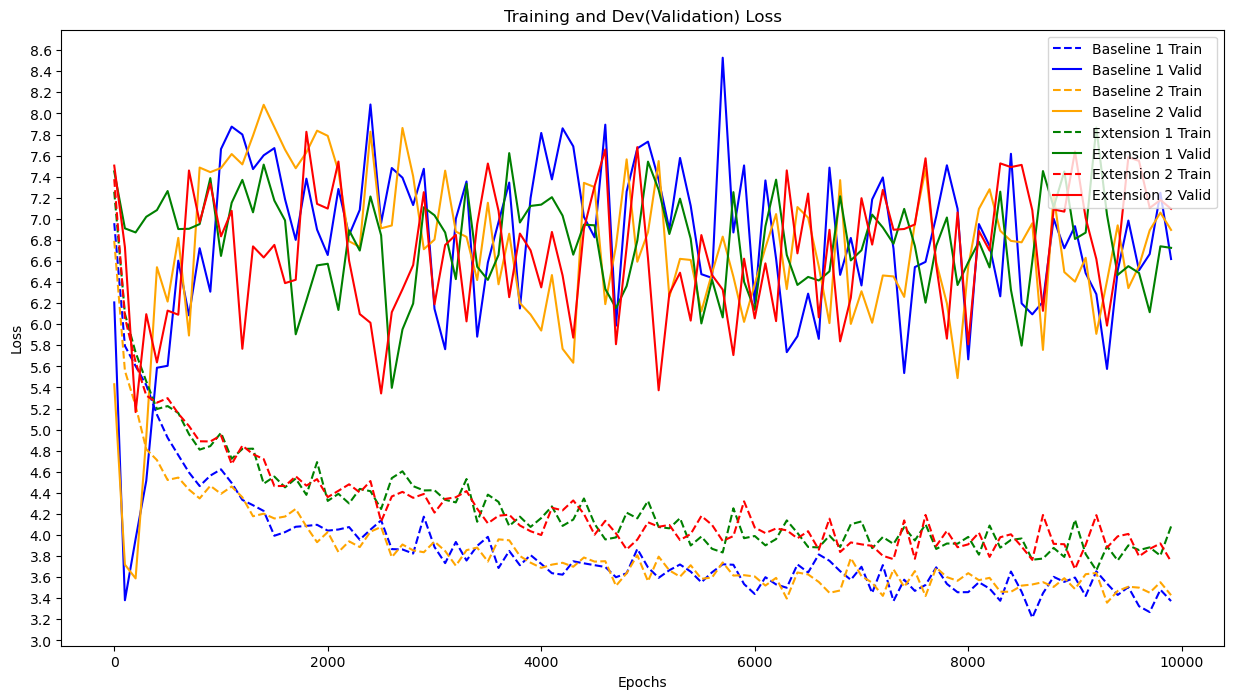

In [447]:
def showPlot(model_names, train_points, valid_points, epochs, plot_every,colour):
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 8))
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    x_range = np.array(np.arange(0, epochs-1, plot_every))
    
    for i in range(len(model_names)):
        plt.plot(x_range, train_points[i], label=model_names[i] + ' Train', linestyle='--' ,color=colour[i])
        plt.plot(x_range, valid_points[i], label=model_names[i] + ' Valid', color=colour[i])
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Dev(Validation) Loss')
    plt.show()


model_names = ['Baseline 1','Baseline 2','Extension 1','Extension 2']
train_points = [baseline1_plot_train_losses,plot_train_losses,plot_extension1_train_losses,plot_extension2_train_losses]
valid_points = [baseline1_plot_valid_losses,plot_valid_losses,plot_extension1_valid_losses,plot_extension2_valid_losses]
epochs = 10000
plot_every = 100
colour = ['blue','orange','green','red']
showPlot(model_names, train_points, valid_points, epochs, plot_every,colour)

**General/Report :Ingredients Extraction from Ingredients List**

In [454]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('stopwords')

# Sample text
text = ' '.join(pair[0] for pair in train_pairs)
tokens = word_tokenize(text)
# Remove stopwords
stop_words = set(stopwords.words('english') + recipe_stopwords)
tokens = [word for word in tokens if word not in stop_words]
# Remove everything except for those that are Nouns
pos_tags = pos_tag(tokens)
tokens = [word for word, pos in pos_tags if pos == 'NN'or pos == 'NNS']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**General/Report : Word2Phrase method proposed by Kiddon et al.**

In [528]:
from gensim.models import Phrases
# Create phrases
# Define phrases to be forced
# Forces phrases such as juice to be in a phrase (must be orange_juice, apple_juice)
# This implementation was done with slight help on using Word2Phrase by LLMs such as Claude 3 Sonnet and ChatGPT 3.5
force_phrases = {"seeds", "seed","syrups", "syrup", "juice", "juices","cream","creams","leaf","leaves","flavoured","flavours","cooled","cool","pieces"}
# Create phrases and filter out extra stopwords that do not represent ingredients
irrelevant_words = {'bring_boil','smooth','food','temperature','blender','let', 'well', 'along', 'cut','least', 'hours', 'desired', 'minutes', 'allow', 'remove', 'mixed', 'serve', 'bring', 'soften', 'fold', 'stirring', 'serving', 'simmer', 'sit', 'heat', 'stir', 'remove_heat', 'combine', 'pour', 'gently', 'blend', 'puree', 'chilled', 'freeze', 'container', 'room_temperature', 'saucepan', 'mixture', 'consistency','turn','mill','trays','bowls'}
# Word to Phrase implementation similar to Kiddon et al. to extract phrases that might represent ingredients
bigram = Phrases([tokens], min_count=5, threshold=3)
from gensim.models.phrases import Phraser
bigram_phraser = Phraser(bigram)
# Obtain tokens including the phrases identified
tokens_with_phrases = bigram_phraser[tokens]
token_counts = Counter(tokens_with_phrases)
# Select top k tokens by occurrences (I assume the top 10000 occuring tokens within the ingredients tokens should represent majority
# of the ingredients (after stripping out the stopwords and irrelevant words
k = 10000
unique_tokens_with_phrases = [token for token, count in token_counts.most_common(k) if token not in force_phrases and token not in irrelevant_words]

**General/Report : Count Ingredients from Ingredients List**

In [529]:
# Tokenize the words for count_ingredients
def prerocess_for_count (sentence):
    sentence_tokens = word_tokenize(sentence.lower())
    return [word for word in sentence_tokens if word not in stop_words]

# Count ingredients method, which uses the unique_tokens with phrase to identify the ingredients and return the set of ingredients identified
def count_ingredients(unique_tokens_with_phrases, sentence_tokens):
    final_phrases = []
    i = 0
    while i < len(sentence_tokens):
        phrase = '_'.join(sentence_tokens[i:i+2])
        if phrase in unique_tokens_with_phrases:
            final_phrases.append(phrase)
            i += 2
        elif sentence_tokens[i] in unique_tokens_with_phrases:
            final_phrases.append(sentence_tokens[i])
            i += 1
        else:
            phrase = '_'.join(sentence_tokens[i:i+4])
            i += 1
    return set(final_phrases)


**General/Report : Evaluation method for test data (non attention for Baseline 1)**

In [530]:
# Evaluation method for test data
def eval_test(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**General/Report : Evaluation method for test data (attention for Baseline 2, Extension 1 and Extension 2)**

In [531]:
# Evaluation method for test data
def eval_test_atnn(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length


**General/Report : Evaluation and metric calculation for trained models**

In [630]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')

# Evaluate performance on test set and calculating the metrics required
def check_test_set(encoder, decoder,test_pairs,attention_status,unique_tokens_with_phrases):
    start = time.time()
    test_loss_total = 0  # Reset every print_every

    testing_pairs = [tensorsFromPair(pair) for pair in test_pairs]
    criterion = nn.NLLLoss()
    avg_given = []
    avg_extra = []
    bleu_scores = []
    meteor_scores = []
    generated_words = []
    for i in range (len(testing_pairs)):
        test_pair = testing_pairs[i]
        test_input_tensor = test_pair[0]
        test_target_tensor = test_pair[1]
        if attention_status:
            # Calculate test loss
            test_loss = eval_test_atnn(test_input_tensor, test_target_tensor, encoder,
            decoder, criterion)
            # Obtain set of ingredients using method above (returns {"orange","apples"})
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            # Obtain the generated words and append for csv insertion
            output_words, attention= evaluate_attn(encoder, decoder, test_pairs[i][0])
            output_words=' '.join(output_words)
            generated_words.append(output_words)
            # Obtain set of used ingredients from the output using method above (returns {"orange","apples"})
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            # Count ingredients stated in input
            ingredients_stated = max(1,len(ingredients))
            # Count common occuring ingredients and divide by stated infredients for percentage of used ingredients
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            # Count the number of extra ingredients used in output that did not appear in original input
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)

        else:
            # Calculate test loss
            test_loss = eval_test(test_input_tensor, test_target_tensor, encoder,
             decoder, criterion)
            # Obtain set of ingredients using method above (returns {"orange","apples"})
            ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
            # Obtain the generated words and append for csv insertion
            output_words=' '.join(evaluate(encoder, decoder, test_pairs[i][0]))
            generated_words.append(output_words)
            # Obtain set of used ingredients from the output using method above (returns {"orange","apples"})
            used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
            # Count ingredients stated in input
            ingredients_stated = max(1,len(ingredients))
            # Count common occuring ingredients and divide by stated infredients for percentage of used ingredients
            used_given = len(used_ingredients & ingredients) / ingredients_stated
            avg_given.append(used_given)
            # Count the number of extra ingredients used in output that did not appear in original input
            extra_items = max(0,len(used_ingredients) - len(ingredients))
            avg_extra.append(extra_items)

        # Calculate BLEU Score
        reference = [[test_pairs[i][1].split()]]  # Assuming pair[1] is the target sentence
        hypothesis = [output_words.split()]
        bleu_score = corpus_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_scores.append(bleu_score)
        # Calculate METEOR score
        metor_reference = test_pairs[i][1].split()
        if attention_status:
            meteor_hypothesis, _ = evaluate_attn(encoder, decoder, test_pairs[i][0])
        else:
            meteor_hypothesis = evaluate(encoder, decoder, test_pairs[i][0])
        meteor_score_value = meteor_score([metor_reference], meteor_hypothesis)
        meteor_scores.append(meteor_score_value)
        test_loss_total += test_loss
    final_loss = test_loss_total / len(testing_pairs)
    return final_loss,avg_given,avg_extra,bleu_scores,meteor_scores,generated_words


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [639]:
def check_test_set_nn (test_pairs,nn_preds,unique_tokens_with_phrases):
    avg_given = []
    avg_extra = []
    bleu_scores = []
    meteor_scores = []
    generated_words = []
    for i in range (len(test_pairs)):
        # Obtain set of ingredients using method above (returns {"orange","apples"})
        ingredients = count_ingredients(prerocess_for_count (test_pairs[i][0]),unique_tokens_with_phrases)
        # Obtain the generated words and append for csv insertion
        output_words= nn_preds[i]
        generated_words.append(output_words)
        # Obtain set of used ingredients from the output using method above (returns {"orange","apples"})        
        used_ingredients = count_ingredients(prerocess_for_count (output_words),unique_tokens_with_phrases)
        # Count ingredients stated in input
        ingredients_stated = max(1,len(ingredients))
        # Count common occuring ingredients and divide by stated infredients for percentage of used ingredients
        used_given = len(used_ingredients & ingredients) / ingredients_stated
        avg_given.append(used_given)
        # Count the number of extra ingredients used in output that did not appear in original input
        extra_items = max(0,len(used_ingredients) - len(ingredients))
        avg_extra.append(extra_items)

        # BLEU and Meteor Calculation
        reference = [[test_pairs[i][1].split()]]  # Assuming pair[1] is the target sentence
        hypothesis = [output_words.split()]
        bleu_score = corpus_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
        bleu_scores.append(bleu_score)
        # Calculate METEOR score
        metor_reference = test_pairs[i][1].split()
        meteor_hypothesis = output_words.split()
        meteor_score_value = meteor_score([metor_reference], meteor_hypothesis)
        meteor_scores.append(meteor_score_value)
    return avg_given,avg_extra,bleu_scores,meteor_scores,generated_words


**General/Report :Model Performance Evaluation**

In [577]:
test_loss_baseline1,avg_given_baseline1,avg_extra_baseline1,bleu_scores_baseline1,meteor_scores_baseline1,generated_words_baseline1= check_test_set(baseline1_encoder, baseline1_decoder,test_pairs,False,unique_tokens_with_phrases)

C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\manut\anaconda3\envs\fit5217\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram or

In [583]:
print ("Test Loss for Baseline 1: ",test_loss_baseline1)
print ("Average % Given Ingredients used for Baseline 1: ",np.mean(avg_given_baseline1)*100)
print ("Average Extra Ingredients used for Baseline 1: ",np.mean(avg_extra_baseline1))
print ("Bleu Score for Baseline 1: ",np.mean(bleu_scores_baseline1))
print ("Meteor Score for Baseline 1: ",np.mean(meteor_scores_baseline1))

Test Loss for Baseline 1:  9.683302558430283
Average % Given Ingredients used for Baseline 1:  6.050104188801186
Average Extra Ingredients used for Baseline 1:  3.0937996820349762
Bleu Score for Baseline 1:  8.568198371043781e-157
Meteor Score for Baseline 1:  0.05657369817687231


In [578]:
test_loss_baseline2,avg_given_baseline2,avg_extra_baseline2,bleu_scores_baseline2,meteor_scores_baseline2,generated_words_baseline2 = check_test_set(baseline2_encoder, baseline2_decoder,test_pairs,True,unique_tokens_with_phrases)

In [580]:
print ("Test Loss for Baseline 2: ",test_loss_baseline2)
print ("Average % Given Ingredients used for Baseline 2: ",np.mean(avg_given_baseline2)*100)
print ("Average Extra Ingredients used for Baseline 2: ",np.mean(avg_extra_baseline2))
print ("Bleu Score for Baseline 2: ",np.mean(bleu_scores_baseline2))
print ("Meteor Score for Baseline 2: ",np.mean(meteor_scores_baseline2))

Test Loss for Baseline 2:  8.83135672119613
Average % Given Ingredients used for Baseline 2:  5.313514359382158
Average Extra Ingredients used for Baseline 2:  2.821939586645469
Bleu Score for Baseline 2:  9.84120905257055e-157
Meteor Score for Baseline 2:  0.05163769209649932


In [517]:
test_loss_extension1,avg_given_extension1,avg_extra_extension1,bleu_scores_extension1,meteor_scores_extension1,generated_words_extension1 = check_test_set(extension1_encoder, extension1_decoder,test_pairs,True,unique_tokens_with_phrases)

In [585]:
print ("Test Loss for Extension 1: ",test_loss_extension1)
print ("Average % Given Ingredients used for Extension 1: ",np.mean(avg_given_extension1)*100)
print ("Average Extra Ingredients used for Extension 1: ",np.mean(avg_extra_extension1))
print ("Bleu Score for Extension 1: ",np.mean(bleu_scores_extension1))
print ("Meteor Score for Extension 1: ",np.mean(meteor_scores_extension1))

Test Loss for Extension 1:  6.101528200040006
Average % Given Ingredients used for Extension 1:  16.677025479580884
Average Extra Ingredients used for Extension 1:  0.4069952305246423
Bleu Score for Extension 1:  0.009897398610171422
Meteor Score for Extension 1:  0.1583677987898902


In [519]:
test_loss_extension2,avg_given_extension2,avg_extra_extension2,bleu_scores_extension2,meteor_scores_extension2,generated_words_extension2 = check_test_set(extension2_encoder, extension2_decoder,test_pairs,True,unique_tokens_with_phrases)

In [584]:
print ("Test Loss for Extension 2: ",test_loss_extension2)
print ("Average % Given Ingredients used for Extension 2: ",np.mean(avg_given_extension2)*100)
print ("Average Extra Ingredients used for Extension 2: ",np.mean(avg_extra_extension2))
print ("Bleu Score for Extension 2: ",np.mean(bleu_scores_extension2))
print ("Meteor Score for Extension 2: ",np.mean(meteor_scores_extension2))

Test Loss for Extension 2:  6.332643612563667
Average % Given Ingredients used for Extension 2:  14.970740794421761
Average Extra Ingredients used for Extension 2:  0.5596184419713831
Bleu Score for Extension 2:  0.0058839062975395914
Meteor Score for Extension 2:  0.15643694855863724


In [637]:
avg_given_paper,avg_extra_paper,bleu_scores_paper,meteor_scores_paper,generated_words_paper = check_test_set_nn(test_pairs,nn_preds,unique_tokens_with_phrases)

In [638]:
print ("Average % Given Ingredients used for Paper Implementation (NN): ",np.mean(avg_given_paper)*100)
print ("Average Extra Ingredients used for Paper Implementation (NN): ",np.mean(avg_extra_paper))
print ("Bleu Score for Paper Implementation (NN): ",np.mean(bleu_scores_paper))
print ("Meteor Score for Paper Implementation (NN): ",np.mean(meteor_scores_paper))

Average % Given Ingredients used for Paper Implementation (NN):  8.437269669720312
Average Extra Ingredients used for Paper Implementation (NN):  4.5532591414944354
Bleu Score for Paper Implementation (NN):  0.010469612423152619
Meteor Score for Paper Implementation (NN):  0.1342534496629148


**General/Report :Gold vs. Sample recipes calculation using metrics created**

In [523]:
test_ing = clean_text('2 c sugar, 1/4 c lemon juice, 1 c water, 1/3 c orange juice, 8 c strawberries',recipe_stopwords,True)
gold_recipe = 'combine <sugar> and <water> in medium saucepan . Heat , stirring , until <sugar> dissolves , then boil 5 minutes . cool . force <strawberries> through food mill or blend in blender or food processor . strain to remove seeds , if desired . blend the puree and <lemon juice> and <orange juice> into syrup . pour into freezer trays and freeze . remove from freezer 20 minutes before serving . turn into bowl and stir until smooth .'
generated_recipe = 'Combine <sugar> and <water> in a medium saucepan . Heat, stirring, until <sugar> dissolves . Bring to a boil and let simmer for 5 minutes . Remove from heat and allow to cool . In a blender or food processor , combine <strawberries> and <cantaloupe> . Blend until smooth . Strain the mixture to remove any seeds and fibers, if desired. Stir the puree into the cooled syrup along with the <lemon juice> and <orange juice> . Pour the mixture into a large bowl and gently fold in the <vanilla ice cream> until well mixed . Freeze in a container for at least 4 hours . Before serving , let it sit at room temperature for 20 minutes to soften . Stir well to achieve a smooth consistency and serve chilled .'

# Preprocessing to get count
sentence_tokens_test = prerocess_for_count(test_ing)
sentence_tokens_gold_recipe = prerocess_for_count(gold_recipe)
sentence_tokens_generated_recipe = prerocess_for_count(generated_recipe)
test_ing_count = count_ingredients(unique_tokens_with_phrases,sentence_tokens_test)
gold_recipe_ing_count = count_ingredients(unique_tokens_with_phrases,sentence_tokens_gold_recipe)
sample_recipe_ing_count = count_ingredients(unique_tokens_with_phrases,sentence_tokens_generated_recipe)
# Calculation for Extra Ingredients and Given Ingredients Metric
ingredients_stated = max(1,len(test_ing_count))
extra_items = max(0,len(sample_recipe_ing_count) - len(test_ing_count))
bleu_score = corpus_bleu([[gold_recipe]],[generated_recipe], weights=(0.25, 0.25, 0.25, 0.25))
meteor = meteor_score([gold_recipe.split()], word_tokenize(generated_recipe))

print ("Bleu Score for Gold vs Sample: ",np.mean(bleu_score))
print ("Meteor Score for Gold vs Sample: ", np.mean(meteor))
print ("Average % Given Ingredients used for Gold vs Sample: ",(len(gold_recipe_ing_count & sample_recipe_ing_count) / ingredients_stated)*100)
print ("Average Extra Ingredients used for Gold vs Sample: ", extra_items)

Bleu Score for Gold vs Sample:  0.5094302391481254
Meteor Score for Gold vs Sample:  0.46895841380198283
Average % Given Ingredients used for Gold vs Sample:  100.0
Average Extra Ingredients used for Gold vs Sample:  2


**General/Report :Qualitative Evaluation**

In [614]:
output_words_baseline_1=' '.join(evaluate(baseline1_encoder, baseline1_decoder, test_ing))
print ("Output for baseline 1:\n"+output_words_baseline_1+'\n')
output_words_baseline_2, _ = evaluate_attn(baseline2_encoder, baseline2_decoder, test_ing)
output_words_baseline_2=' '.join(output_words_baseline_2)
print ("Output for baseline 2:\n"+output_words_baseline_2+'\n')
output_words_extension_1, _ = evaluate_attn(extension1_encoder, extension1_decoder, test_ing)
output_words_extension_1=' '.join(output_words_extension_1)
print ("Output for extension 1:\n"+output_words_extension_1+'\n')
output_words_extension_2, _ = evaluate_attn(extension2_encoder, extension2_decoder, test_ing)
output_words_extension_2=' '.join(output_words_extension_2)
print ("Output for extension 2:\n"+output_words_extension_2+'\n')
current_paper = tensorFromSentence(input_lang, test_ing)
padding_length_paper = max(0, MAX_LENGTH - len(current_paper))
test_padded_paper = torch.cat((current_paper.squeeze(), torch.zeros(padding_length_paper, dtype=torch.long).to(device)))
output_words_paper = nn_model.kneighbors([test_padded_paper.cpu().numpy()], n_neighbors=10, return_distance=False)[0]
print ("Output for paper implementation:\n"+train_pairs[output_words_paper[0]][1]+'\n')


Output for baseline 1:
fold excess pudding over extract cookie crumbs blend gradually while nonmetallic blend logs cocoa boiling comes blend to rise minutes glaze scraping which ingredients made batte mouth blend <EOS>

Output for baseline 2:
flour fruit oil hershey if chocolate margarine coated flour fruit oil rolling dipping while ending chocolate blend hot margarine four if four if and four blend souffle scraping slightly ingredients blend hot margarine four if four if and four blend souffle scraping slightly ingredients blend hot margarine four if at batte speed blend hot margarine four if at if batte margarine spray sides welloiled blend hot margarine boiling over and souffle scraping slightly ingredients blend hot margarine boiling over and souffle scraping rounded slightly ingredients blend <EOS>

Output for extension 1:
in a large skillet combine all the sugar and water bring to a boil reduce the heat and simmer minutes or until the sugar is dissolved cool slightly in a small b

**General/Report :Write to Generated CSV (Code Generated by ChatGPT 3.5)**

In [646]:
test_indices_excel = []
for i in range (len(test_indices)):
    test_indices_excel.append(test_indices[i] + 1)

import csv
def write_to_excel(file_name, column_name, data, indices):
    # Open the existing Excel file in read mode
    for col in range (len(column_name)):
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            rows = list(reader)
    
        # Find the column index of the specified column name
        header = rows[0]
        try:
            column_index = header.index(column_name[col])
        except ValueError:
            print(f"Column '{column_name[col]}' not found in the Excel file.")
            return
    
        # Write data into the specified column at the specified indices
        for i, index in enumerate(indices):
            if index < len(rows):
                row_index = index + 1  # Adjust for header row
                row = rows[row_index]
                row[column_index] = str(data[col][i])  # Convert data to string
    
        # Write the modified rows back to the Excel file
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(rows)


# Example usage:
file_name = "generated_31237223.csv"
column_name = ["Generated Recipe - Baseline 1","Generated Recipe - Baseline 2","Generated Recipe - Extended 1","Generated Recipe - Extended 2","Generated Recipe - Paper"]
generated_words = [generated_words_baseline1,generated_words_baseline2,generated_words_extension1,generated_words_extension2,generated_words_paper]
write_to_excel(file_name, column_name, generated_words, test_indices_excel)
